**Market Risk Indicator**

[*********************100%%**********************]  4 of 4 completed


Ticker       EVZ        ^GSPC       ^MOVE       ^VIX
Date                                                
2024-07-24  0.32  5427.129883   94.809998  18.040001
2024-07-25  0.32  5399.220215   99.080002  18.459999
2024-07-26  0.32  5459.100098   97.760002  16.389999
2024-07-29  0.32  5463.540039   98.650002  16.600000
2024-07-30  0.32  5436.439941  100.419998  17.690001
Skipping index 1504 because out of bounds.
Skipping index 1505 because out of bounds.
Skipping index 1506 because out of bounds.
Skipping index 1507 because out of bounds.
Skipping index 1508 because out of bounds.
Skipping index 1504 because out of bounds.
Skipping index 1505 because out of bounds.
Skipping index 1506 because out of bounds.
Skipping index 1507 because out of bounds.
Skipping index 1508 because out of bounds.


/var/folders/w6/pmmfklps59z60whl_87vd6gm0000gn/T/ipykernel_69641/2369607572.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_val = y[-1]
/var/folders/w6/pmmfklps59z60whl_87vd6gm0000gn/T/ipykernel_69641/2369607572.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_val = y[-1]


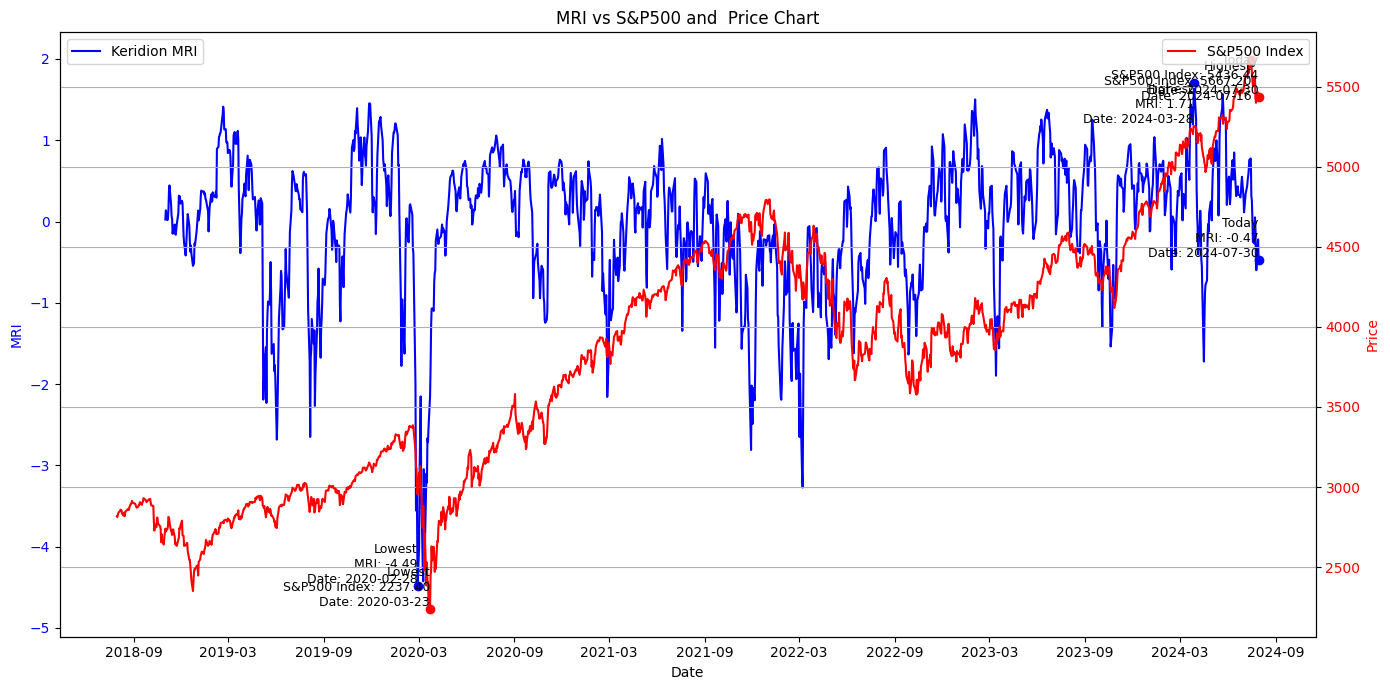

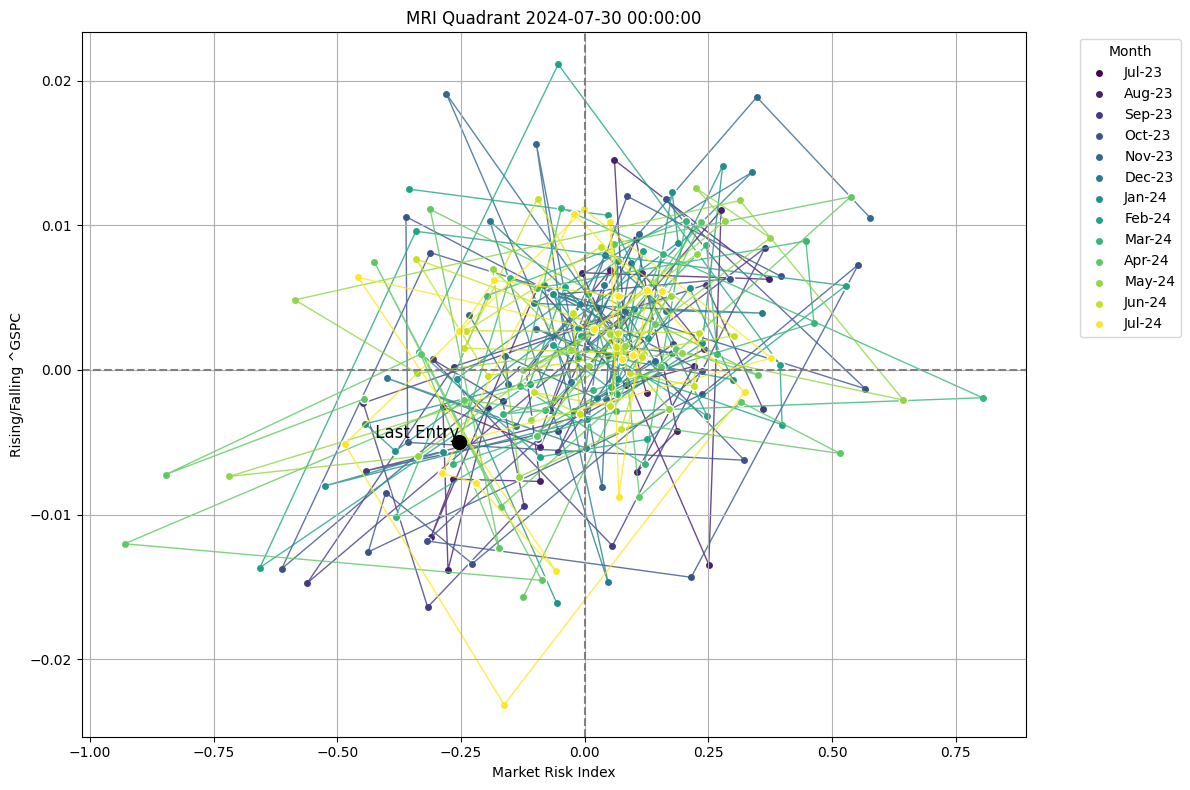

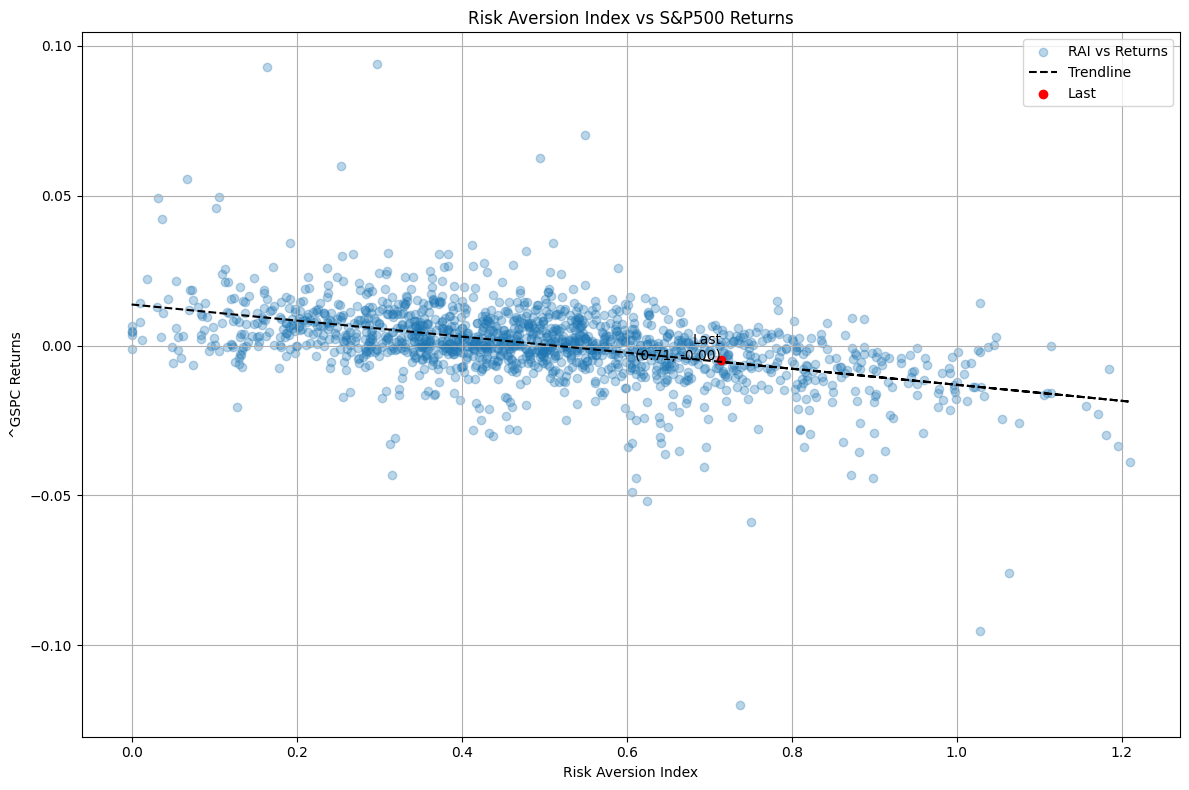

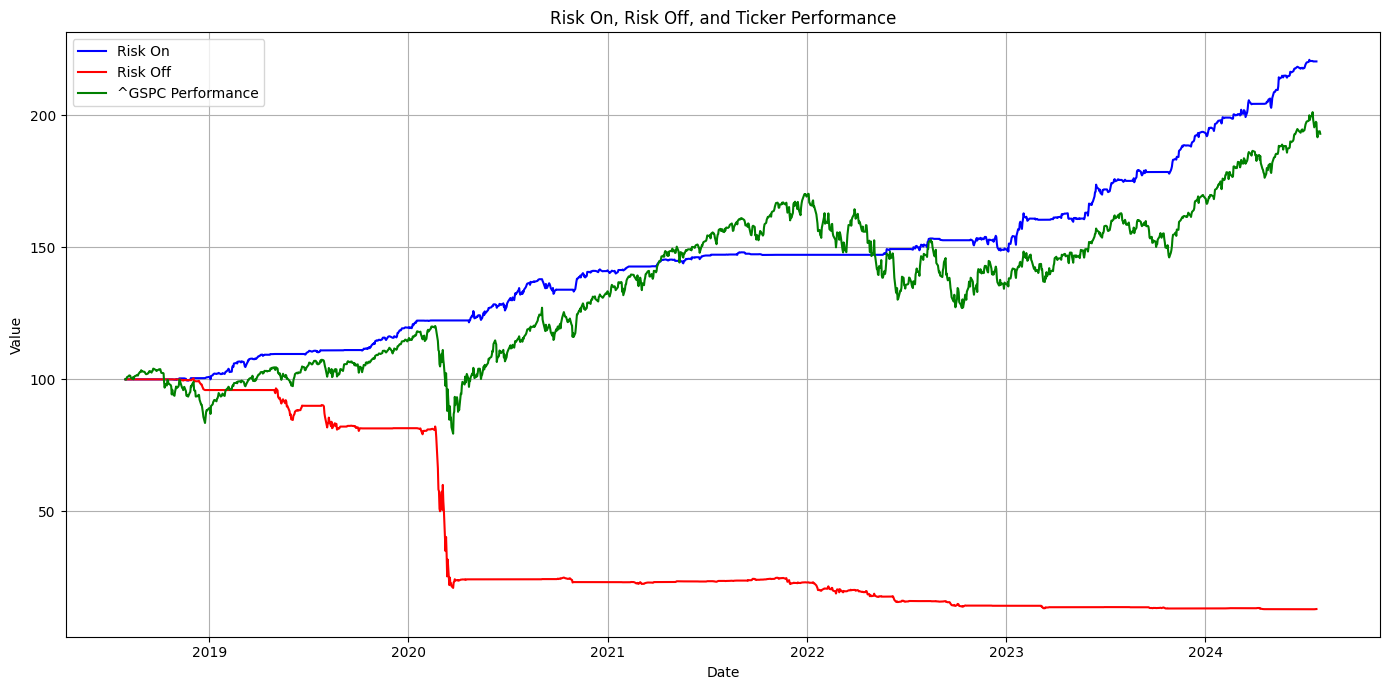

In [252]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

def get_data(tickers, start_date, end_date):
    try:
        data = yf.download(tickers, start=start_date, end=end_date)
        data = data['Close'].ffill().bfill()  # Forward-fill NaNs, then backward-fill if needed
        return data
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return pd.DataFrame()

def calculate_mri(data, lookback_periods, weights, slope_factor):
    daily_returns = (data - data.shift(1)) / data.shift(1)
    comparison_index = daily_returns[['^VIX', '^MOVE', 'EVZ']]
    mri_list = []

    for lookback in lookback_periods:
        offset_values = {}
        for ticker in comparison_index.columns:
            offset_values[ticker] = -comparison_index[ticker].rolling(window=lookback).sum()
        offset_values_df = pd.DataFrame(offset_values).dropna()

        nm_value = pd.DataFrame(index=offset_values_df.index)
        for ticker in offset_values_df.columns:
            rolling_min = offset_values_df[ticker].rolling(window=lookback).min()
            rolling_max = offset_values_df[ticker].rolling(window=lookback).max()
            nm_value[ticker] = np.where(
                (rolling_max - rolling_min) != 0,
                (offset_values_df[ticker] - rolling_min) / (rolling_max - rolling_min),
                0
            )

        absolute_values = np.abs(2 * nm_value - 1)
        z_scores = pd.DataFrame(index=offset_values_df.index)

        for ticker in comparison_index.columns:
            rolling_mean = data[ticker].rolling(window=lookback).mean()
            rolling_std = data[ticker].rolling(window=lookback).std()
            valid_index = rolling_mean.index.intersection(offset_values_df.index)
            z_scores = z_scores.reindex(valid_index)

            z_scores[ticker] = np.where(
                rolling_std.loc[valid_index] > 0,
                (data[ticker].loc[valid_index] - rolling_mean.loc[valid_index]) / rolling_std.loc[valid_index],
                0
            )

        combo_rhs = -1 * (z_scores * absolute_values).sum(axis=1) / absolute_values.sum(axis=1)
        mri_list.append(combo_rhs)

    mri_avg = pd.concat(mri_list, axis=1).mean(axis=1) * slope_factor
    mri = (0.33 * mri_avg + 0.67 * mri_avg.shift(1)) / 10
    mri.fillna(0, inplace=True)

    return mri


def calculate_risk_aversion_index(data, lookback_periods, weights):
    daily_returns = (data - data.shift(1)) / data.shift(1)
    comparison_index = daily_returns[['^VIX', '^MOVE', 'EVZ']]
    
    normalization_indices = []
    
    for lookback in lookback_periods:
        norm_df = pd.DataFrame(index=comparison_index.index)
        for ticker in comparison_index.columns:
            max_idx = comparison_index[ticker].rolling(window=lookback).max()
            min_idx = comparison_index[ticker].rolling(window=lookback).min()
            normalization = (comparison_index[ticker] - min_idx) / (max_idx - min_idx)
            normalization = normalization.fillna(0)
            norm_df[ticker] = normalization
        
        combo_values = norm_df.apply(lambda row: np.dot(row, weights), axis=1)
        normalization_indices.append(combo_values)
    
    combined_normalization_indices = pd.concat(normalization_indices, axis=1).mean(axis=1)
    sum_weights = sum(weights)
    risk_aversion_index = 2 * (combined_normalization_indices / sum_weights) - 1
    
    return risk_aversion_index

def calculate_risk_on(data, mri, ticker_returns):
    risk_on = pd.Series(index=data.index, dtype=float)
    risk_on.iloc[0] = 100  # First entry starts from 100
    
    for i in range(1, len(risk_on)):
        if i >= len(mri) or i >= len(ticker_returns):
            print(f"Skipping index {i} because out of bounds.")
            continue
        
        mri_slice = mri.iloc[max(0, i-30):i]
        sum_mri = mri_slice.sum()
        sign_T = 1 if sum_mri > 0 else -1 if sum_mri < 0 else 0
        
        yesterday_mri_slow = mri.iloc[i-1]
        current_return = ticker_returns.iloc[i]
        
        V = (max(0, yesterday_mri_slow)) * current_return
        risk_on.iloc[i] = risk_on.iloc[i-1] * (1 + V)
    
    return risk_on

def calculate_risk_off(data, mri, ticker_returns):
    risk_off = pd.Series(index=data.index, dtype=float)
    risk_off.iloc[0] = 100  # First entry starts from 100
    
    for i in range(1, len(risk_off)):
        if i >= len(mri) or i >= len(ticker_returns):
            print(f"Skipping index {i} because out of bounds.")
            continue
        
        yesterday_mri_slow = mri.iloc[i-1]
        current_return = ticker_returns.iloc[i]
        
        X = (min(0, yesterday_mri_slow)) * current_return
        risk_off.iloc[i] = risk_off.iloc[i-1] * (1 - X)
    
    return risk_off

def calculate_ticker_performance(data, ticker_returns):
    ticker_performance = pd.Series(index=data.index, dtype=float)
    ticker_performance.iloc[0] = 100  # First entry starts from 100
    
    for i in range(1, len(ticker_performance)):
        if i >= len(ticker_returns):
            print(f"Skipping index {i} because out of bounds.")
            continue
        
        current_return = ticker_returns.iloc[i]
        ticker_performance.iloc[i] = ticker_performance.iloc[i-1] * (1 + current_return)
    
    return ticker_performance

def annotate_points(ax, x, y, label, color):
    highest_idx = y.idxmax()
    highest_val = y.max()
    ax.plot(highest_idx, highest_val, 'o', color=color)
    ax.text(highest_idx, highest_val, f'Highest\n{label}: {highest_val:.2f}\nDate: {highest_idx.strftime("%Y-%m-%d")}', 
            color='black', fontsize=9, ha='right', va='top')
    lowest_idx = y.idxmin()
    lowest_val = y.min()
    ax.plot(lowest_idx, lowest_val, 'o', color=color)
    ax.text(lowest_idx, lowest_val, f'Lowest\n{label}: {lowest_val:.2f}\nDate: {lowest_idx.strftime("%Y-%m-%d")}', 
            color='black', fontsize=9, ha='right', va='bottom')
    today_idx = y.index[-1]
    today_val = y[-1]
    ax.plot(today_idx, today_val, 'o', color=color)
    ax.text(today_idx, today_val, f'Today\n{label}: {today_val:.2f}\nDate: {today_idx.strftime("%Y-%m-%d")}', 
            color='black', fontsize=9, ha='right', va='bottom')

def plot_data(data, mri, gspc_ticker='^GSPC', user_ticker=None, start_date=None, end_date=None):
    if start_date and end_date:
        data = data.loc[start_date:end_date]
        mri = mri.loc[start_date:end_date]
    
    plt.figure(figsize=(14, 7))
    
    ax1 = plt.gca()
    ax1.plot(mri.index, mri, label='Keridion MRI', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('MRI', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    annotate_points(ax1, mri.index, mri, 'MRI', 'blue')
    
    ax2 = ax1.twinx()
    ax2.plot(data.index, data[gspc_ticker], label='S&P500 Index', color='red')
    annotate_points(ax2, data.index, data[gspc_ticker], 'S&P500 Index', 'red')
    
    if user_ticker and user_ticker in data.columns:
        ax2.plot(data.index, data[user_ticker], label=f'{user_ticker} Price', color='green')
        annotate_points(ax2, data.index, data[user_ticker], f'{user_ticker} Price', 'green')
    
    ax2.set_ylabel('Price', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    mri_min, mri_max = mri.min(), mri.max()
    margin = (mri_max - mri_min) * 0.1
    ax1.set_ylim(mri_min - margin, mri_max + margin)
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.title(f"MRI vs S&P500 and {user_ticker} Price Chart")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_quadrant_chart(mri_dif, daily_returns, ticker):
    plt.figure(figsize=(12, 8))
    df = pd.DataFrame({'MRI': mri_dif, 'Returns': daily_returns})
    end_date = df.index.max()
    start_date = end_date - pd.DateOffset(months=12)
    df = df.loc[start_date:end_date]
    df['Month'] = df.index.to_period('M')
    months = df['Month'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(months)))
    month_labels = [month.start_time.strftime('%b-%y') for month in months]
    for month, color, label in zip(months, colors, month_labels):
        month_data = df[df['Month'] == month]
        plt.scatter(month_data['MRI'], month_data['Returns'], c=[color], label=label, edgecolors='w')
        plt.plot(month_data['MRI'], month_data['Returns'], color=color, alpha=0.8, linestyle='-', linewidth=1, zorder=1)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')
    last_entry = df.iloc[-1]
    plt.scatter(last_entry['MRI'], last_entry['Returns'], color='black', s=100, edgecolor='black', zorder=2)
    plt.text(last_entry['MRI'], last_entry['Returns'], ' Last Entry', color='Black', fontsize=12, ha='right', va='bottom')
    plt.xlabel('Market Risk Index')
    plt.ylabel(f'Rising/Falling {ticker}')
    plt.title(f'MRI Quadrant {end_date}')
    plt.grid(True)
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_risk_aversion_vs_returns(risk_aversion, returns, ticker):
    valid_mask = ~risk_aversion.isna() & ~returns.isna()
    risk_aversion = risk_aversion[valid_mask]
    returns = returns[valid_mask]

    if risk_aversion.empty or returns.empty:
        print("No valid data to plot.")
        return
    
    plt.figure(figsize=(12, 8))
    plt.scatter(risk_aversion, returns, alpha=0.3, label='RAI vs Returns')

    if len(risk_aversion) > 0 and len(returns) > 0:
        model = LinearRegression()
        model.fit(risk_aversion.values.reshape(-1, 1), returns.values.reshape(-1, 1))
        trendline = model.predict(risk_aversion.values.reshape(-1, 1))
        plt.plot(risk_aversion, trendline, color='black', linestyle='--', label='Trendline')

        last_point = len(risk_aversion) - 1
        plt.scatter(risk_aversion.iloc[last_point], returns.iloc[last_point], color='red', label='Last')
        plt.text(risk_aversion.iloc[last_point], returns.iloc[last_point],
                 f'Last\n({risk_aversion.iloc[last_point]:.2f}, {returns.iloc[last_point]:.2f})', 
                 horizontalalignment='right')

    plt.title('Risk Aversion Index vs S&P500 Returns')
    plt.xlabel('Risk Aversion Index')
    plt.ylabel(f'{ticker} Returns')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_risk_on_risk_off_performance(risk_on, risk_off, ticker_performance, selected_ticker):
    plt.figure(figsize=(14, 7))
    
    plt.plot(risk_on.index, risk_on, label='Risk On', color='blue')
    plt.plot(risk_off.index, risk_off, label='Risk Off', color='red')
    plt.plot(ticker_performance.index, ticker_performance, label=f'{selected_ticker} Performance', color='green')
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Risk On, Risk Off, and Ticker Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Execution
tickers = ['^VIX', '^MOVE', 'EVZ', '^GSPC']
start_date = (datetime.datetime.now() - pd.DateOffset(years=6)).strftime('%Y-%m-%d')

user_ticker = input("Enter the ticker symbol of a stock you want to add (or press Enter to use ^GSPC): ").upper()
if user_ticker:
    if user_ticker not in tickers:
        tickers.append(user_ticker)
    selected_ticker = user_ticker
else:
    selected_ticker = '^GSPC'

end_date_input = input("Enter the end date (YYYY-MM-DD) or press Enter to use the current date: ")
if end_date_input:
    end_date = end_date_input
else:
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')

data = get_data(tickers, start_date, end_date)
if data.empty:
    print("No data available.")
else:
    print(data.tail())

    # Previous calculations
    lookback_periods_fast = [5, 10, 22, 66, 90]
    lookback_periods_slow = [66, 126, 190, 252, 520]
    slope_factor_fast = 10
    slope_factor_slow = 22

    weights_input = input("Enter the weights for ^VIX, ^MOVE, and EVZ (comma separated, in percentage): ")
    if weights_input:
        try:
            weights = [float(w) / 100 for w in weights_input.split(',')]
            if sum(weights) != 1:
                raise ValueError("Weights must sum to 1.")
        except ValueError as e:
            print(f"Invalid weights input: {e}. Using default weights.")
            weights = [1/3, 1/3, 1/3]
    else:
        weights = [1/3, 1/3, 1/3]

    data_mri_fast = calculate_mri(data, lookback_periods_fast, weights, slope_factor_fast)
    data_mri_slow = calculate_mri(data, lookback_periods_slow, weights, slope_factor_slow)
    data_mri_combined = (data_mri_fast + data_mri_slow) / 2

    data_rai_fast = calculate_risk_aversion_index(data, lookback_periods_fast, weights)
    data_rai_slow = calculate_risk_aversion_index(data, lookback_periods_slow, weights)
    data_rai_combined = (data_rai_fast + data_rai_slow) / 2

    daily_returns = data[selected_ticker].pct_change()
    mri_dif = data_mri_combined.diff()

    # Calculate new series
    risk_on = calculate_risk_on(data, data_mri_combined, daily_returns)
    risk_off = calculate_risk_off(data, data_mri_combined, daily_returns)
    ticker_performance = calculate_ticker_performance(data, daily_returns)

    # Plot results
    plot_data(data, data_mri_combined, gspc_ticker='^GSPC', user_ticker=user_ticker, start_date=start_date, end_date=end_date)
    plot_quadrant_chart(mri_dif, daily_returns, selected_ticker)
    plot_risk_aversion_vs_returns(data_rai_combined, daily_returns, selected_ticker)
    plot_risk_on_risk_off_performance(risk_on, risk_off, ticker_performance, selected_ticker)


In [250]:
data_mri_combined

Date
2018-08-07         NaN
2018-08-08         NaN
2018-08-09         NaN
2018-08-10         NaN
2018-08-13         NaN
                ...   
2024-07-24   -0.111523
2024-07-25   -0.596519
2024-07-26   -0.597297
2024-07-29   -0.220105
2024-07-30   -0.473482
Length: 1504, dtype: float64